In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp /content/drive/'My Drive'/'Colab Notebooks'/Image_classification_data.zip .
!unzip -q -o Image_classification_data.zip
!rm Image_classification_data.zip
!ls

data_labels_extraData.csv  drive     patch_images
data_labels_mainData.csv   __MACOSX  sample_data


In [3]:
import numpy as np 
from sklearn.model_selection import train_test_split 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns


data = pd.read_csv('./data_labels_mainData.csv') 

In [4]:
data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [5]:
data.count() #no missing values

InstanceID      9896
patientID       9896
ImageName       9896
cellTypeName    9896
cellType        9896
isCancerous     9896
dtype: int64

**Data Pre-processing**

In [6]:
#drop IDs
data.drop(['InstanceID', 'patientID'], axis = 1, inplace =True)
target = data['cellType']
data['ImgPath'] = './patch_images/' + data['ImageName']
data.head()

,ImageName,cellTypeName,cellType,isCancerous,ImgPath
0,22405.png,fibroblast,0,0,./patch_images/22405.png
1,22406.png,fibroblast,0,0,./patch_images/22406.png
2,22407.png,fibroblast,0,0,./patch_images/22407.png
3,22408.png,fibroblast,0,0,./patch_images/22408.png
4,22409.png,fibroblast,0,0,./patch_images/22409.png


In [7]:
CELLTYPE_OUTPUT_CLASSES = 4

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42) 

train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42) 

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0])) 

target = train_data['cellType']

Train data : 5937, Val Data: 1979, Test Data: 1980


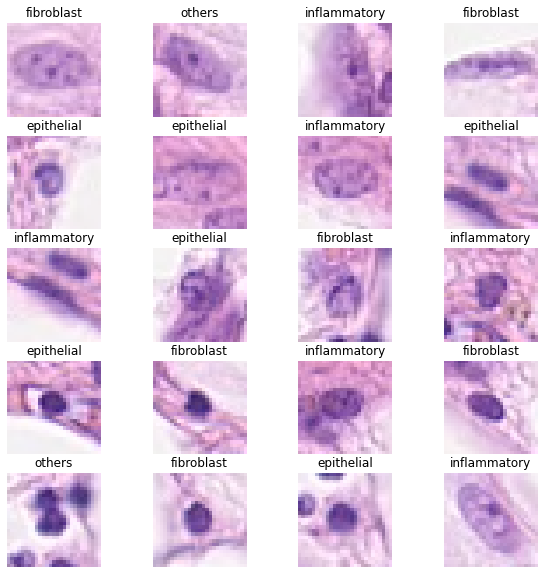

In [61]:
from PIL import Image

label_names = {'fibroblast':0, 'inflammatory':1, 'epithelial':2, 'others':3}
d_inv = {v: k for k, v in label_names.items()}

img_list = list('./patch_images/' + data['ImageName'])
target_list = list(target)
fig = plt.figure(figsize = [10, 10])
for i in np.arange(20):
    plt.subplot(5, 4, i + 1)
    img = Image.open(img_list[i])

    plt.imshow(img)
    plt.title(d_inv[target_list[i]])
    plt.axis('off')


In [ ]:
img = Image.open(img_list[100])
img_numpy = np.ascontiguousarray(img, dtype=np.float32)
print('Image size \nH:{} W:{} C:{}'.format(img_numpy.shape[0], img_numpy.shape[1], img_numpy.shape[2]))

Image size 
H:27 W:27 C:3


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


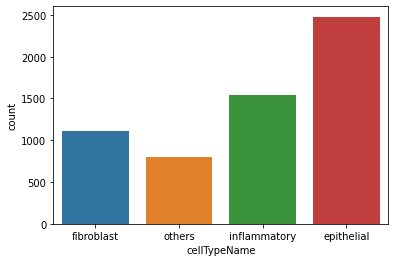

In [ ]:
sns.countplot(train_data['cellTypeName'])

In [ ]:
train_data.head()
pd.DataFrame(train_data).dtypes

ImageName       object
cellTypeName    object
cellType         int64
isCancerous      int64
ImgPath         object
dtype: object

In [12]:
train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="ImgPath",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="ImgPath",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


**VGG Model**

In [8]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [9]:
reg_lambda = 0.001

vgg_model = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(CELLTYPE_OUTPUT_CLASSES),
])

In [10]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)
vgg_model.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


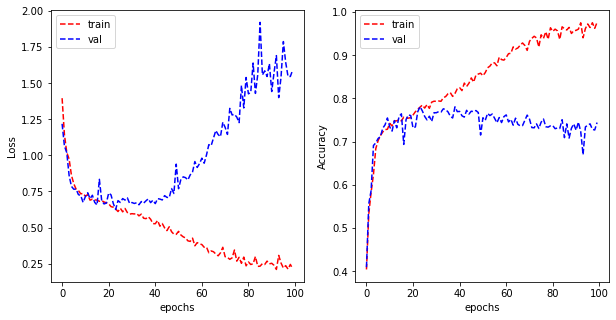

In [13]:
vgg_model_history = vgg_model.fit(train_generator, validation_data = validation_generator, epochs=100, verbose=0)

plot_learning_curve(vgg_model_history.history['loss'], vgg_model_history.history['val_loss'], 
                    vgg_model_history.history['categorical_accuracy'], vgg_model_history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
reg_lambda = 0.001

model_2 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(CELLTYPE_OUTPUT_CLASSES),
])

In [ ]:
model_2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

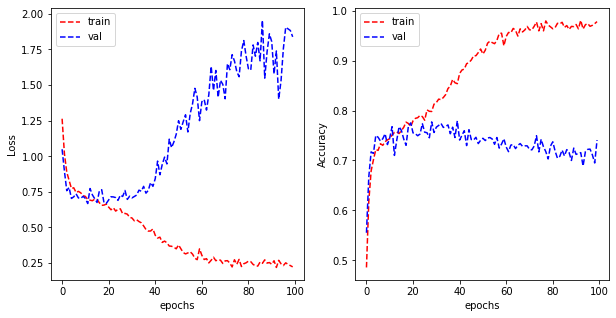

In [ ]:
history_2 = model_2.fit(train_generator, validation_data = validation_generator, epochs=100, verbose=0)

plot_learning_curve(history_2.history['loss'], history_2.history['val_loss'], 
                    history_2.history['categorical_accuracy'], history_2.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [53]:
#data augmentation

train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=15, width_shift_range=0.2,
                                   height_shift_range=0.2, brightness_range=[0.5,1.5])
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="ImgPath",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="ImgPath",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [ ]:
reg_lambda = 0.001

model_3 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(CELLTYPE_OUTPUT_CLASSES),
])

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)
model_3.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history_3 = model_3.fit(train_generator, validation_data = validation_generator, epochs=100, verbose=0)

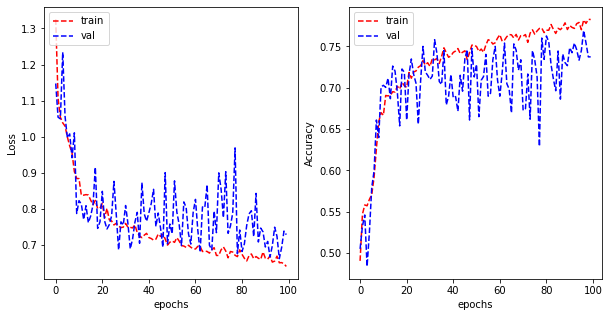

In [ ]:
history_3 = model_3.fit(train_generator, validation_data = validation_generator, epochs=100, verbose=0)

plot_learning_curve(history_3.history['loss'], history_3.history['val_loss'], 
                    history_3.history['categorical_accuracy'], history_3.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')


In [54]:
reg_lambda = 0.001

model_4 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(CELLTYPE_OUTPUT_CLASSES),
])

In [69]:
import time
start = time.time()

In [70]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)
model_4.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [71]:
history_4 = model_4.fit(train_generator, validation_data = validation_generator, epochs=100, verbose=0)

In [72]:
end = time.time()

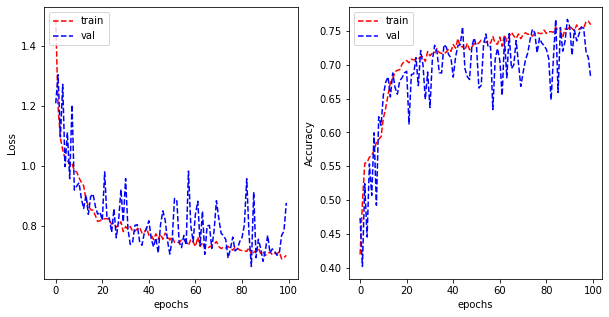

In [56]:
plot_learning_curve(history_4.history['loss'], history_4.history['val_loss'], 
                    history_4.history['categorical_accuracy'], history_4.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [73]:
print(f"Training time: {end - start}s")

Training time: 599.2838449478149s


In [66]:
print(f"Average Training Accuracy: {np.mean(history_4.history['categorical_accuracy'])}")

Average Training Accuracy: 0.7105170947313308


In [68]:
print(f"Average Training Accuracy: {np.mean(history_4.history['loss'])}")

Average Training Accuracy: 0.7959753692150116


In [ ]:
#Transfer Learning
new_model = tf.keras.Sequential()
for layer in model_3.layers[:-1]: # just exclude last layer from copying
  new_model.add(layer)
for layer in model_3.layers:
  layer.trainable = False

new_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 27, 27, 32)        896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 6, 6, 128)        

**Xception Model**

In [37]:
#data augmentation

train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=15, width_shift_range=0.2,
                                   height_shift_range=0.2, brightness_range=[0.5,1.5])
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="ImgPath",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='sparse')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="ImgPath",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='sparse')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [43]:
input_tensor = tf.keras.layers.Input(shape=(27, 27, 3))
model = tf.keras.applications.Xception(weights= None, include_top=False, input_tensor=input_tensor)

In [44]:
x = model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.7)(x)
predictions = tf.keras.layers.Dense(CELLTYPE_OUTPUT_CLASSES, activation= 'softmax')(x)
xcept = tf.keras.models.Model(inputs = model.input, outputs = predictions)

In [45]:
import time
start = time.time()

In [46]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [47]:
history = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 10, epochs = 100, verbose=0)

In [48]:
end = time.time()

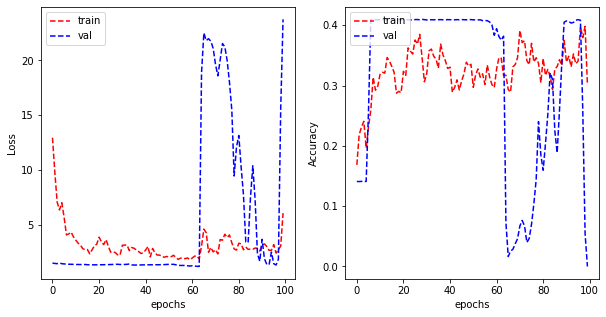

In [49]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['accuracy'], 
                    history.history['val_accuracy'], 
                    metric_name='Accuracy')

In [50]:
print(f"Training time: {end - start}s")

Training time: 245.76330971717834s


In [51]:
print(f"Average Training Accuracy: {np.mean(history.history['accuracy'])}")

Average Training Accuracy: 0.3243321044743061


In [52]:
print(f"Average Training Loss: {np.mean(history.history['loss'])}")

Average Training Loss: 3.166911963224411


**Test Model**

In [58]:
#Testing Model
test_data['cellType'] = test_data['cellType'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./',
        x_col="ImgPath",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 1980 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
model_3.evaluate(test_generator)

1980/1980 [==============================] - 6s 3ms/step - loss: 0.7839 - categorical_accuracy: 0.7242


[0.7839395403862, 0.7242424488067627]

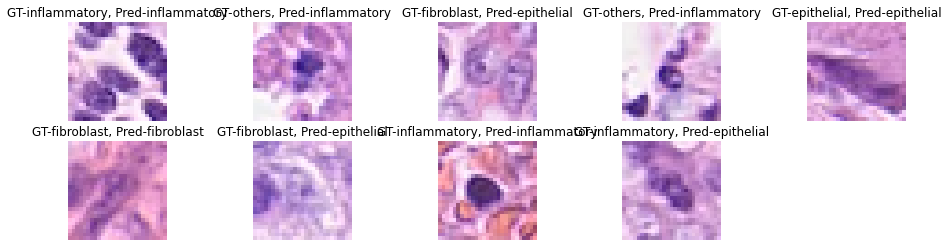

In [ ]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model_3.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 10:
            plt.subplot(2,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

In [59]:
model_4.evaluate(test_generator)

1980/1980 [==============================] - 7s 3ms/step - loss: 0.9152 - categorical_accuracy: 0.6742


[0.9152007699012756, 0.6742424368858337]

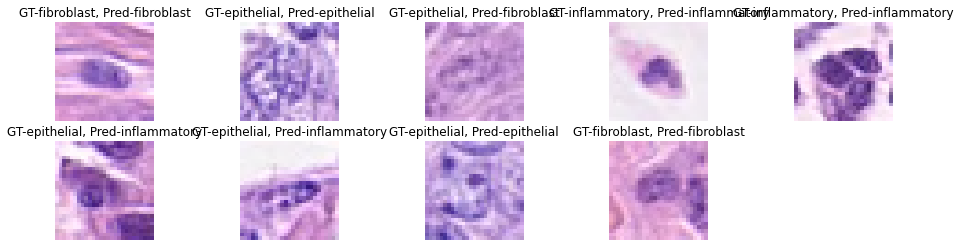

In [62]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model_4.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 10:
            plt.subplot(2,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

**Transfer Learning**

In [ ]:
extraData = pd.read_csv('./data_labels_extraData.csv')

extraData.drop(['InstanceID', 'patientID'], axis = 1, inplace =True)
extraData['ImgPath'] = './sample_data/' + extraData['ImageName']
extraData.head()

,ImageName,isCancerous,ImgPath
0,12681.png,0,./sample_data/12681.png
1,12682.png,0,./sample_data/12682.png
2,12683.png,0,./sample_data/12683.png
3,12684.png,0,./sample_data/12684.png
4,12685.png,0,./sample_data/12685.png


In [ ]:
extraData.count()

ImageName      10384
isCancerous    10384
ImgPath        10384
dtype: int64

In [ ]:
data.head()

,ImageName,cellTypeName,cellType,isCancerous,ImgPath
0,22405.png,fibroblast,0,0,./patch_images/22405.png
1,22406.png,fibroblast,0,0,./patch_images/22406.png
2,22407.png,fibroblast,0,0,./patch_images/22407.png
3,22408.png,fibroblast,0,0,./patch_images/22408.png
4,22409.png,fibroblast,0,0,./patch_images/22409.png


In [ ]:
model_3.trainable = False

In [ ]:
inputs = tf.keras.Input(shape=(27, 27, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
# A Dense classifier with a single unit (binary classification)
outputs = tf.keras.layers.Dense(CELLTYPE_OUTPUT_CLASSES)
new_model = tf.keras.Model(inputs, outputs)

ValueError: ignored